In [ ]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes,edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        #modified label definition
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label,           n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:
import math

class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 #at initializtion, op is not affected by Value object
        self._backward = lambda: None # None for leaf nodes in the graph
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"


    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        """
        ^ to work with non-value objects by wrapping them around Value and thereby providing them a data attribute
        eg: to perform a + 1 (where 1 is not a Value object)
        """
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            print(out.data)
            self.grad += 1.0 * out.grad
            """
            using += instead of + to accumulate gradients instead of overwriting (in the case of adding a node to itself)
            """
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out


    def __neg__(self): # -self
        return self * -1


    def __radd__(self, other): # other + self
        return self + other


    def __sub__(self, other): # self - other
        return self + (-other)


    def __rsub__(self, other): # other - self
        return other + (-self)


    def __rmul__(self, other): # other * self
        return self * other


    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        print(t)
        out = Value(t, (self, ), 'tanh')
        print(out.grad)

        def _backward():
            print(out.grad,self.grad)
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def sigmoid(self):
        x = self.data
        s = 1 / (1 + math.exp(-x))
        out = Value(s, (self, ), 'sigmoid')
        def _backward():
            self.grad += s * (1 - s) * out.grad
        out._backward = _backward
        return out


    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        print(topo)
        self.grad = 1.0
        for node in reversed(topo):
            print(node)
            node._backward()

0.7615941559557649
0.0
[Value(data=7), Value(data=-3.0), Value(data=2.0), Value(data=-6.0), Value(data=0.0), Value(data=1.0), Value(data=0.0), Value(data=-6.0), Value(data=1.0), Value(data=0.7615941559557649)]
Value(data=0.7615941559557649)
1.0 0.0
Value(data=1.0)
1.0
Value(data=-6.0)
-6.0
Value(data=0.0)
Value(data=1.0)
Value(data=0.0)
Value(data=-6.0)
Value(data=2.0)
Value(data=-3.0)
Value(data=7)


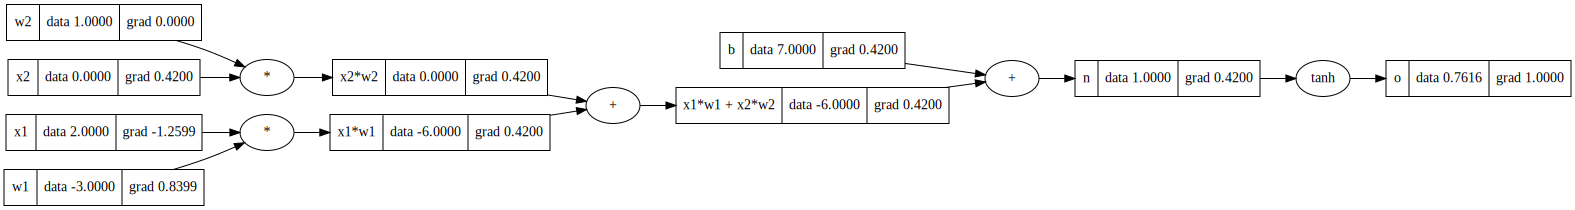

In [ ]:
#Forward Pass
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(7, label='b')
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

#Backward Pass
o.backward()
print()
#Graph
draw_dot(o)